Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


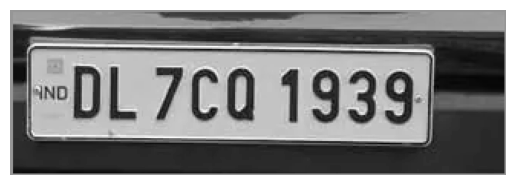

Extracted Number Plate: DL 7CQ 1939
Insurance: Expired
PUC: Expired
Details sent to RTO for further proceedings.


In [22]:
import cv2
import easyocr
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Load the dataset
df = pd.read_csv("D:/Downloads/vehicle_data_1000.csv") # Assuming dataset.csv has Vehicle_Number, Insurance_Expiry, and PUC_Expiry columns

# Initialize the EasyOCR reader
reader = easyocr.Reader(['en'])

# Load the number plate classifier
plate_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_russian_plate_number.xml')

# Image path
image_path = r"D:\Downloads\a7sp8ji_high-security-number-plates_625x300_12_October_18.webp"

# Read the image
car_image = cv2.imread(image_path)

if car_image is None:
    print(f"Error: Unable to load image from {image_path}")
else:
    # Convert the image to grayscale for detection
    gray_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)

    # Detect number plates in the image
    plates = plate_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(plates) > 0:
        for (x, y, w, h) in plates:
            # Draw rectangle around the detected number plate (optional)
            cv2.rectangle(car_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Crop the detected number plate from the image
            number_plate = car_image[y:y + h, x:x + w]

            # Convert the cropped number plate to grayscale
            number_plate_gray = cv2.cvtColor(number_plate, cv2.COLOR_BGR2GRAY)

            # Display the grayscale number plate using matplotlib
            plt.imshow(number_plate_gray, cmap='gray')  # Display in grayscale
            plt.axis('off')  # Hide axes
            plt.show()

            # Use EasyOCR to extract text from the number plate
            result = reader.readtext(number_plate_gray)

            # Extract the recognized text
            recognized_texts = []
            for detection in result:
                recognized_texts.append(detection[1])

            if recognized_texts:
                # Format the recognized text
                formatted_text = recognized_texts[1].upper() if len(recognized_texts) > 1 else recognized_texts[0].upper()
                print(f"Extracted Number Plate: {formatted_text}")

                # Check the vehicle status in the CSV file
                record = df[df["Vehicle_Number"] == formatted_text]

                if record.empty:
                    print("Vehicle not found in the dataset.")
                else:
                    # Get the expiry dates for Insurance and PUC
                    insurance_expiry_date = record["Insurance_Expiry"].values[0]
                    puc_expiry_date = record["PUC_Expiry"].values[0]

                    # Convert the expiry dates to datetime objects
                    insurance_expiry_date = datetime.strptime(insurance_expiry_date, '%d-%m-%Y')
                    puc_expiry_date = datetime.strptime(puc_expiry_date, '%d-%m-%Y')

                    # Get today's date
                    today_date = datetime.today()

                    # Check insurance and PUC status
                    if insurance_expiry_date < today_date:
                        insurance_status = "Expired"
                    else:
                        insurance_status = "Valid"

                    if puc_expiry_date < today_date:
                        puc_status = "Expired"
                    else:
                        puc_status = "Valid"

                    # Print the status
                    print(f"Insurance: {insurance_status}")
                    print(f"PUC: {puc_status}")

                    if insurance_status == "Expired" or puc_status == "Expired":
                        print("Details sent to RTO for further proceedings.")
                    else:
                        print("All is OK.")
            else:
                print("No text recognized from the number plate.")
    else:
        print("No number plate detected.")
